In [45]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
from collections import OrderedDict
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from shutil import copyfile
import scipy


np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 1. #embedding radius
dim = 2 #manifold dimension
dimnoise = 2 #manifold dimension (not in mflasso paper)
cores = 3 

In [47]:
nreps = 5
#new_MN = True
#new_grad = True
savename = 'ethanol_021521'
savefolder = 'ethanol'
loadfolder = 'ethanol'
loadname = 'ethanol_021521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

folder = workingdirectory + '/Figures/ethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

In [49]:
natoms = 9
experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.atoms3, experiment.da = experiment.get_atoms_3()

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
data_xyz_loaded = scipy.io.loadmat(data_wd + '/untracked_data/chemistry_data/ethanol.mat')
angle_indices = np.load(data_wd + '/untracked_data/chemistry_data/ethanolindices022119.npy')
experiment.positions =  data_xyz_loaded['R'][angle_indices]
filename_angles = data_wd + '/untracked_data/chemistry_data/ethanolangles022119.npy'
data = np.arccos(np.reshape(np.load(filename_angles), (50000, experiment.da)))

In [50]:
experiment.M = RiemannianManifold(data, dim)#experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [79]:
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel

In [80]:
nreps = 1

In [53]:
def get_grads3(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    #n = len(selected_points)
    df_M2 = experiment.normalize(df_M)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform(dg_w[j]) for j in range(len(selected_points))])

    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = np.einsum('n b d, n p b -> n p d', subM.tb.tangent_bases, dgw_norm) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [78]:
def get_grads4(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    #n = len(selected_points)
    df_M2 = experiment.normalize(df_M)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform(dg_w[j]) for j in range(len(selected_points))])

    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = np.einsum('n b d, n p b -> n p d', subM.tb.tangent_bases, dgw_norm) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [82]:
replicates[0].dg_M.shape

(100, 756, 2)

In [55]:
experiment.svd.singular_values_ 

array([4114.25494216,  510.2556844 ,  427.74954664,  356.75957149,
        203.3773883 ,  123.07227443,  116.01246278,  100.61611164,
         98.45882164,   89.4090744 ,   86.76114751,   74.92626377,
         63.04176682,   56.58398032,   49.47728122,   45.88995194,
         45.04091016,   44.46293554,   30.58687334,   28.18872749,
         27.54418564,   26.96983645,   26.69615873,   24.77924594,
         23.02451051,   21.96837356,   21.80973748,   21.31281919,
         19.57312432,   19.3646635 ,   18.65964856,   17.62236025,
         17.22500203,   16.45948997,   15.26334261,   14.88963681,
         14.6974414 ,   14.41182983,   13.51102343,   12.75942226,
         12.39515788,   11.12681937,   10.96248779,   10.32981077,
         10.08497186,    9.33330145,    8.88699566,    8.81483235,
          8.60959412,    8.24495064])

In [56]:
experiment.svd.components_.shape

(50, 252)

In [57]:
np.linalg.norm(experiment.svd.components_, axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [58]:
prj_notscaled = np.einsum('b a, n a -> n b',experiment.svd.components_ , experiment.M.data)

In [59]:
np.linalg.norm(experiment.Mpca.data, axis = 0)

array([4114.25494216,  510.2556844 ,  427.74954664,  356.75957149,
        203.3773883 ,  123.07227443,  116.01246278,  100.61611164,
         98.45882164,   89.4090744 ,   86.76114751,   74.92626377,
         63.04176682,   56.58398032,   49.47728122,   45.88995194,
         45.04091016,   44.46293554,   30.58687334,   28.18872749,
         27.54418564,   26.96983645,   26.69615873,   24.77924594,
         23.02451051,   21.96837356,   21.80973748,   21.31281919,
         19.57312432,   19.3646635 ,   18.65964856,   17.62236025,
         17.22500203,   16.45948997,   15.26334261,   14.88963681,
         14.6974414 ,   14.41182983,   13.51102343,   12.75942226,
         12.39515788,   11.12681937,   10.96248779,   10.32981077,
         10.08497186,    9.33330145,    8.88699566,    8.81483235,
          8.60959412,    8.24495064])

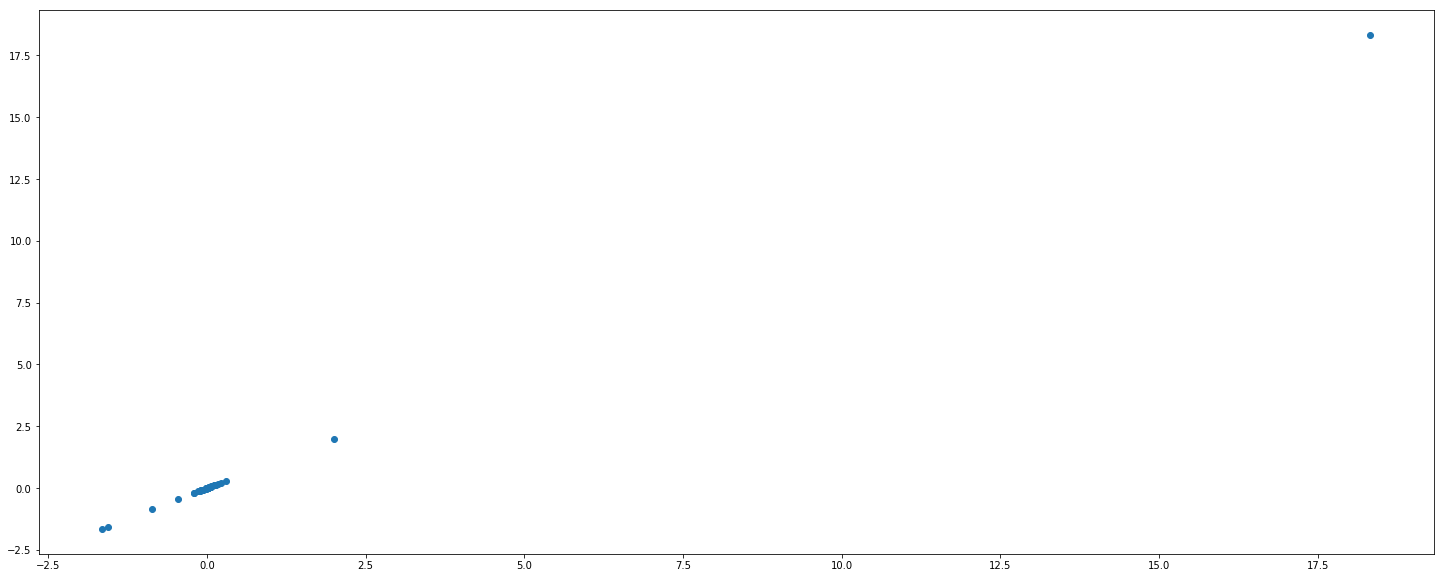

In [60]:
plt.scatter(experiment.Mpca.data[0],prj_notscaled[0])

In [61]:
#does transform use signular values or singular values squared?

In [37]:
selected_points = np.asarray(list(range(10)))

In [38]:
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
nreps = 1
for i in range(nreps):
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0])
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


pre-gradient acquisition 2021-02-18 20:49:30.139369


In [39]:
replicates[i].dg_M.shape #should be 100

(100, 756, 2)

In [109]:
gl_itermax = 500
r = 0 
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
results= {}
for r in range(nreps):
    ul = np.linalg.norm(np.einsum('n m d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    
    #to fix...
    replicates[r].dg_M = np.swapaxes(replicates[r].dg_M,1,2)
    replicates[r].df_M = np.swapaxes(replicates[r].df_M,1,2)
    replicates[r].results = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, dim, tol,learning_rate)

initializing lambda search
converged 1086.8550475804373
0 543.4275237902186 probe
1 815.141285685328 probe
2 950.9981666328827 probe
converged 950.9981666328827
3 883.0697261591054 probe
converged 883.0697261591054
4 849.1055059222167 probe
5 866.087616040661 probe
converged 866.087616040661
6 874.5786710998832 probe
converged 874.5786710998832
we did it [721 745]


In [110]:
sel

{0: array([214, 739])}

In [111]:
replicates[r].dg_M.shape

(100, 2, 756)

In [112]:
from einops import rearrange#replicates[r].dg_M

In [113]:
nreps = 1
for r in range(nreps):
    #r = 0 
    cs = rearrange(np.asarray(list(replicates[r].results[1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(replicates[r].results[1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(nreps):
    #zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [114]:
#pretty slow
a4, p = get_all_atoms_4(9)
g_mf_inc2 = np.zeros((1,2,50000))
for r in range(nreps):
    for o in range(2):
        print(o)
        g_mf_inc2[r,o] =  experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[sel[r][o]])

0
1


Text(0.5, 0, '$\\phi_3$')

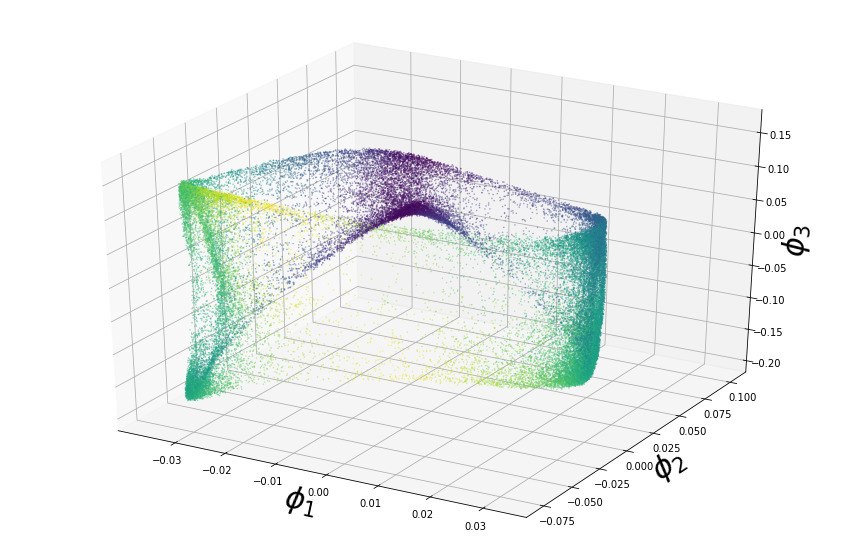

In [115]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,0], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


Text(0.5, 0, '$\\phi_3$')

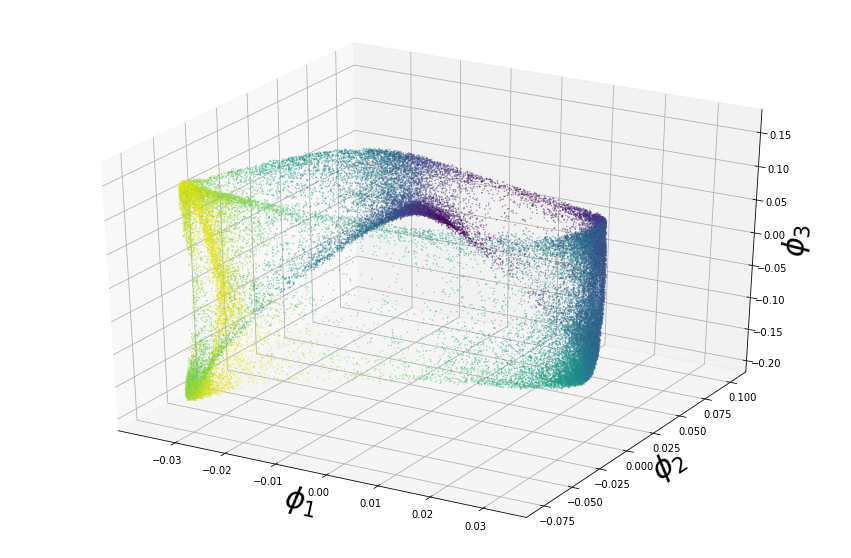

In [116]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,1], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

Text(0.5, 0, '$\\phi_3$')

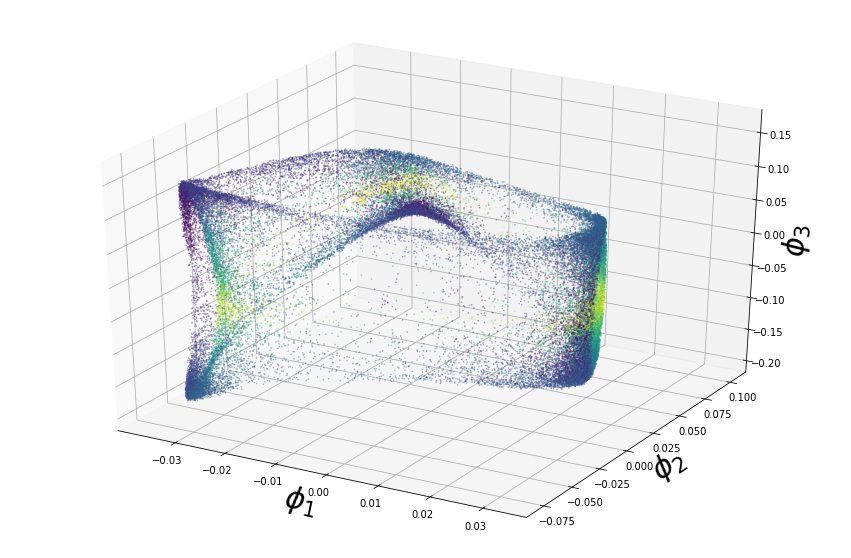

In [100]:
#10 points {0: array([214, 739])}
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,0], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


Text(0.5, 0, '$\\phi_3$')

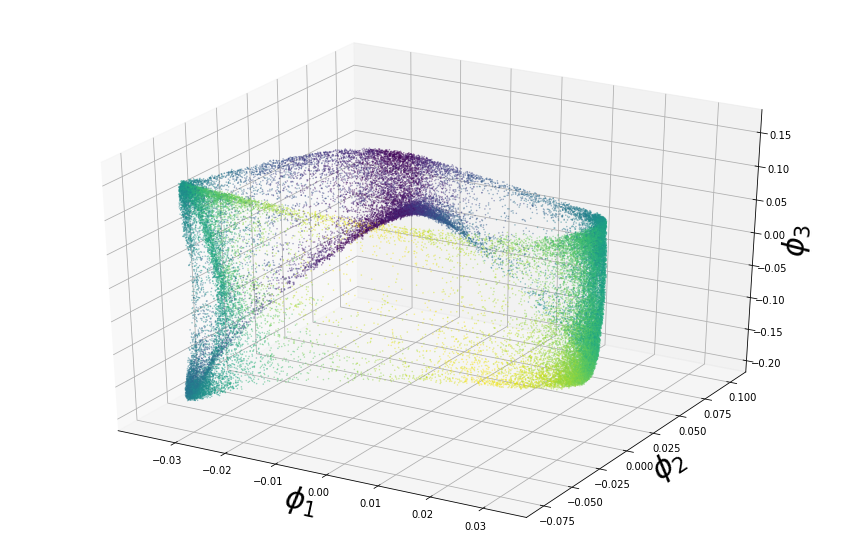

In [101]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,1], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

In [96]:
experiment.atoms4[[sel[r]][o]]

array([[0, 8, 7, 2],
       [5, 4, 7, 8]])

In [98]:
experiment.atoms4[[sel[r]]]

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([[0, 8, 7, 2],
       [5, 4, 7, 8]])

In [64]:

sp = np.asarray([16215, 49362, 19182, 18592, 49137, 22288, 33303, 24487,  9851,
       18010, 14923,   473,  6696, 43574, 22256,  7345, 30498, 37444,
       23306, 18568, 20719, 16613,  5449, 31904, 27301, 21321, 14799,
       17370, 16440, 13743, 30374, 23904,  7957, 12666, 23161,  3581,
       20040, 37326, 25515, 31674, 37251, 34756, 19735,  7506,  6464,
        7428,  6885, 10172, 44424,  9368, 25457, 48791, 28860, 29399,
        6052, 27010, 13498, 42576, 38368, 40955, 11658, 24212, 19112,
        3600, 43800, 12911, 18539, 45952, 46354, 22614,  9057,  8499,
       41901, 15552, 18995,  8862, 46522, 11032,  6227, 36776, 36392,
       39113, 31308,  7973,  4861, 12368, 24716, 23979, 24628, 36028,
       38922, 27212, 40210,  8180, 32033, 11462, 27260,  7752,  9394,
       20369])
#selected_points = sp

In [81]:
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
nreps = 1
for i in range(nreps):
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0], selected_points=sp)
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


pre-gradient acquisition 2021-02-19 09:17:16.146672


In [121]:

def get_incoherent_dictionary_abscos_include(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = np.abs(get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include))#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0)
    keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))


In [83]:
dg_M_full = replicates[i].dg_M

In [126]:
def get_cos_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                #if ind[j] != k:
                coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    
    return (coses)

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

In [141]:
include = np.asarray([74,176])
thresh = .7
incoherent_indices = {}
nreps = 1
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary_abscos_include(np.swapaxes(dg_M_full, 1,2), thresh, include)
    #replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]

(100, 2, 756)
36


In [142]:
incoherent_indices #include largest point with cosine less than .7 with all included points

{0: array([ 74, 176, 423, 324, 330, 751, 750, 120, 268, 269, 292, 681, 701,
        306, 252, 300, 270, 311, 275, 274, 754, 753, 340,  11, 336, 339,
          4,  41,   7,   1,   8,  98, 338,  92, 523, 317, 527, 524, 128])}

In [137]:
incoherent_indices #include largest point with cosine less than .8... stricted criteria for exclusion... more points

{0: array([ 74, 176, 662, 649, 655, 414, 417, 665, 422, 708, 653, 404, 744,
        318, 698, 738, 720, 659, 423, 324, 752, 330, 648, 654, 405, 751,
        421, 660, 475, 517, 481, 750, 114, 120, 463, 499, 102, 415, 403,
        535, 125, 290, 268, 304, 254, 542, 544, 302, 266, 269, 305, 256,
        272, 536, 301, 265, 545, 293, 289, 292, 257, 253, 683, 539, 267,
        532, 309, 681, 531, 533, 701, 306, 695, 252, 307, 264, 310, 699,
        270, 311, 275, 271, 274, 755, 754, 753, 694, 143, 561, 549, 555,
        550, 562, 556, 316, 340, 315, 312,  99, 112,   5,  93,  11, 100,
        336,  94,   3, 339,  96,  90, 337,  37, 341,   9,  10,  41, 113,
          7,   1,   8,   6,   0, 131, 127, 110, 109,  98, 338,  38, 314,
        130, 313,  92, 523, 317, 527, 524, 126, 129, 522, 128, 525])}

In [144]:
replicates[r].dg_M.shape

(100, 756, 2)

In [149]:
class Rep():
    
    def __init(self):
        
        2+2

In [155]:
#replicates[r].df_M = np.swapaxes( replicates[r].df_M,1,2)

In [156]:
nreps = 1
for r in range(nreps):
    #replicates[r].dg_M = np.swapaxes(replicates[r].dg_M,1,2)[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Rep()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, dim, tol,learning_rate)


initializing lambda search
converged 963.9331191237574
0 481.9665595618787 probe
1 722.949839342818 probe
converged 722.949839342818
we did it [2 3]


In [159]:
incoherent_indices[0][[2,3]]

array([423, 324])

In [ ]:
#subsetting what was selected wont change selection properties
#basic corollary of convex duality

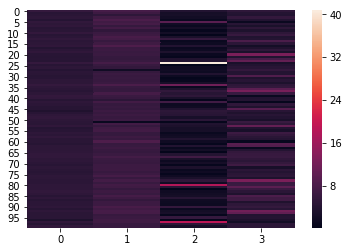

In [85]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms = np.linalg.norm(replicates[0].dg_M[:,trueandsel,:], axis = 2)
%matplotlib inline
sns.heatmap(norms)

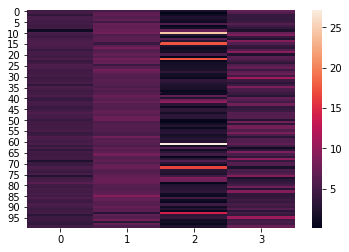

In [44]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms = np.linalg.norm(replicates[0].dg_M[:,trueandsel,:], axis = 2)
%matplotlib inline
sns.heatmap(norms)

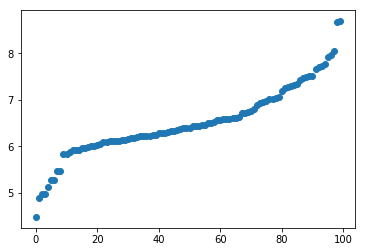

In [176]:
plt.scatter(list(range(100)), norms[norms[:,1].argsort(),1])

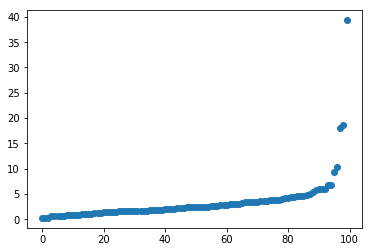

In [174]:
plt.scatter(list(range(100)), norms[norms[:,2].argsort(),2])

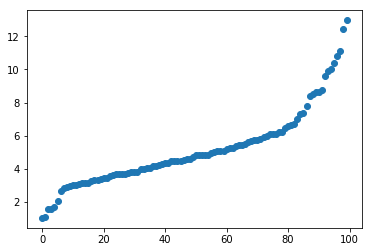

In [175]:
plt.scatter(list(range(100)), norms[norms[:,3].argsort(),3])

In [182]:
rmind = np.concatenate([np.where(norms[:,3] > 10)[0],np.where(norms[:,2] > 10)[0]])

In [341]:
rmind2 = np.where(norms[:,2] > 10)[0]

In [342]:
np.where(norms[:,2] > 10)

(array([ 5, 24, 80, 97]),)

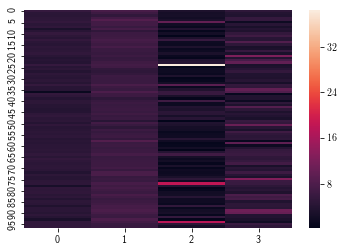

In [306]:
sns.heatmap(norms)

In [343]:
kpind2= np.setdiff1d(list(range(100)), rmind2)

In [344]:
rmind2

array([ 5, 24, 80, 97])

In [273]:
kpind = np.setdiff1d(list(range(100)), rmind)

In [319]:
kpind2.shape

(96,)

In [185]:
sp_sub = sp[kpind]

In [345]:
sp_sub2 = sp[kpind2]

In [363]:
rm3 = np.unique(np.concatenate([rmind2, np.asarray([14, 20, 23, 37, 53, 56, 61, 62, 67, 78, 80, 86, 87, 92, 93])]))

In [364]:
kpind3 = np.setdiff1d(list(range(100)), rm3)

In [365]:
sp_sub23y = sp[kpind3]

In [367]:
kpind3

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
       19, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58,
       59, 60, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79,
       81, 82, 83, 84, 85, 88, 89, 90, 91, 94, 95, 96, 98, 99])

In [366]:
sp_sub23y.shape

(82,)

In [346]:
#need function specific get_grads

In [368]:
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
nreps = 1
for i in range(nreps):
    replicates[i] = Replicate(nsel = len(sp_sub23y), n = experiment.M.data.shape[0], selected_points=sp_sub23y)
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


pre-gradient acquisition 2021-02-17 14:44:45.818171


In [350]:
replicates[i].dg_M.shape

(96, 756, 2)

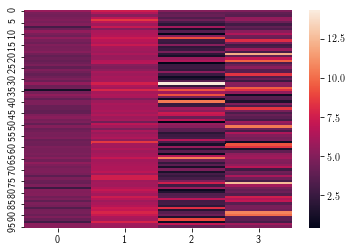

In [351]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms = np.linalg.norm(np.swapaxes(replicates[r].dg_M,1,2)[:,:,np.asarray(trueandsel)], axis = 1)
%matplotlib inline
sns.heatmap(norms)

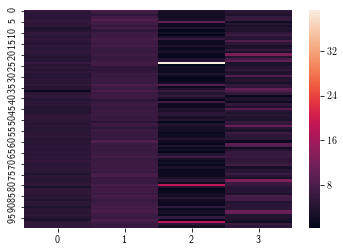

In [326]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms = np.linalg.norm(np.swapaxes(replicates[r].dg_M,1,2)[:,:,np.asarray(trueandsel)], axis = 1)
%matplotlib inline
sns.heatmap(norms)

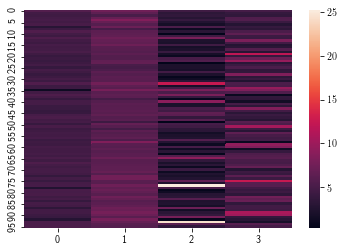

In [317]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms = np.linalg.norm(np.swapaxes(replicates[r].dg_M,1,2)[:,:,np.asarray(trueandsel)], axis = 1)
%matplotlib inline
sns.heatmap(norms)

In [323]:
norms_sp2 = norms.copy()

In [328]:
kp2

NameError: name 'kp2' is not defined

In [333]:
kpind2

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99])

In [339]:
norms[:,2].argsort()

array([25, 11, 51, 65, 82, 41, 31, 96, 21,  9, 61, 71, 73, 94, 32, 83, 63,
       91, 56,  7, 20, 89, 17, 35, 28, 75, 69, 43, 15, 44, 26, 30, 18, 57,
       27, 14, 79, 87, 88, 74, 58, 76,  6, 60,  3, 84, 10, 33, 92, 64, 55,
       85, 70, 54,  1, 99,  2, 68, 49, 93,  4, 40, 19, 72, 77,  0, 12, 53,
       16, 46, 29, 36, 52, 62, 81, 22, 45, 38,  8, 23, 66, 59, 86, 50, 98,
       48, 47, 78, 90, 95, 13, 39, 37, 42, 67, 34,  5, 97, 80, 24])

In [322]:
norms_dgm.shape

(97, 4)

In [282]:
replicates[0].nsel = len(sp_sub2)

In [283]:
replicates[0].nsel 

97

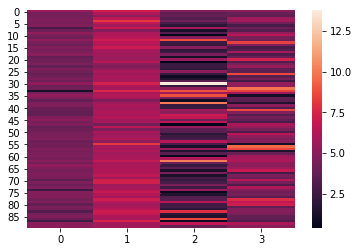

In [191]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms = np.linalg.norm(np.swapaxes(replicates[r].dg_M,1,2)[:,:,trueandsel], axis = 1)
%matplotlib inline
sns.heatmap(norms)

In [204]:
replicates[r].dg_M.shape

(90, 2, 4)

In [292]:
np.linalg.norm(replicates[r].dg_M, axis = tuple([0,1]))

array([45.75300469, 63.80392031, 55.49484231, 54.68581896])

In [205]:
np.linalg.norm(np.swapaxes(replicates[r].dg_M,1,2), axis = tuple([0,2]))

array([42.27294981, 58.91561601, 43.81232931, 49.10491169])

In [369]:
replicates[r].dg_M = replicates[r].dg_M[:,trueandsel,:]

In [370]:
replicates[r].dg_M = np.swapaxes(replicates[r].dg_M, 1,2)

In [371]:
replicates[r].df_M= np.swapaxes(replicates[r].df_M, 1,2)

In [372]:
nreps = 1
for r in range(nreps):
    #replicates[r].dg_M = np.swapaxes(replicates[r].dg_M,1,2)[:,:,incoherent_indices[r]]
    p = 4#np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Rep()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, dim, tol,learning_rate)


initializing lambda search
converged 546.4212409004344
0 273.2106204502172 probe
converged 273.2106204502172
we did it [0 1]


In [288]:
replicates[r].dg_M.shape

(97, 2, 4)

In [199]:
g_324 =  experiment.get_g_full_sub(experiment.M.data, a4[324])

Text(0.5, 0, '$\\phi_3$')

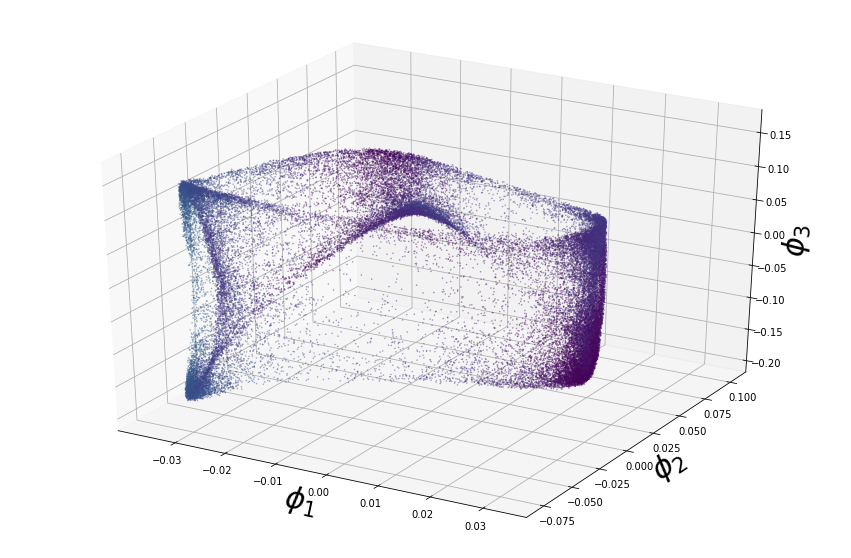

In [200]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_324, alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


In [201]:
g_176 =  experiment.get_g_full_sub(experiment.M.data, a4[176])

In [207]:
#downsample based on dgw
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
nreps = 1
for i in range(nreps):
    replicates[i] = Replicate(nsel = len(sp), n = experiment.M.data.shape[0], selected_points=sp)
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


pre-gradient acquisition 2021-02-17 10:25:29.013871


In [297]:
replicates[i].dg_M.shape

(97, 2, 4)

Text(0.5, 1.0, '$\\|\\nabla_D g_j\\| $')

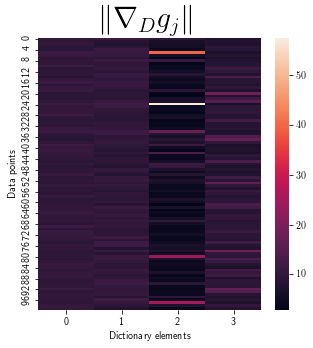

In [262]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms_dgw = np.linalg.norm(replicates[r].dgw_norm[:,trueandsel,:], axis = 2)
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(norms_dgw[:], ax = ax)
plt.xlabel('Dictionary elements')
plt.ylabel('Data points')
plt.title(r'$\|\nabla_D g_j\| $')

Text(0.5, 1.0, '$\\|grad_M g_j\\| $')

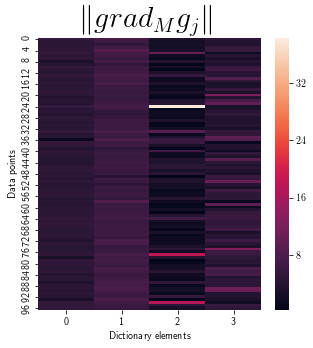

In [296]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms_dgm = np.linalg.norm(replicates[r].dg_M, axis = 1)
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(norms_dgm[:], ax = ax)
plt.xlabel('Dictionary elements')
plt.ylabel('Data points')
plt.title(r'$\|grad_M g_j\| $')

Text(0.5, 1.0, '$\\|grad_M g_j\\| $')

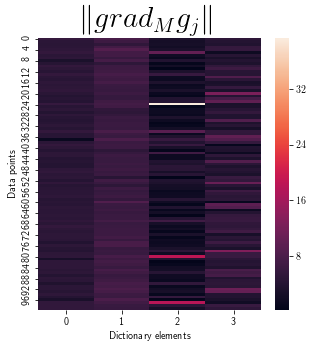

In [265]:
trueandsel = [74,176,423,324]
#norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
norms_dgm = np.linalg.norm(replicates[r].dg_M[:,trueandsel,:], axis = 2)
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(norms_dgm[:], ax = ax)
plt.xlabel('Dictionary elements')
plt.ylabel('Data points')
plt.title(r'$\|grad_M g_j\| $')

In [212]:
norms_dgw.shape

(100, 50)

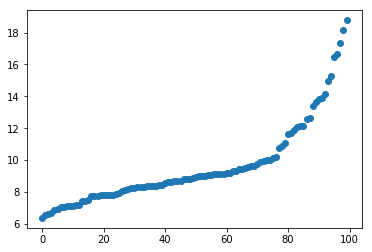

In [215]:
plt.scatter(list(range(100)), norms_dgw[norms_dgw[:,3].argsort(),3])

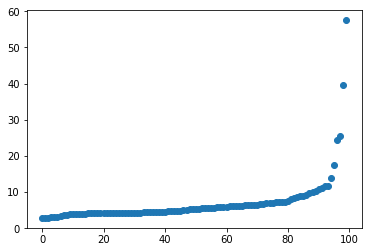

In [216]:
plt.scatter(list(range(100)), norms_dgw[norms_dgw[:,2].argsort(),2])

In [226]:
np.linalg.norm(np.einsum('n m d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([0,2]))[trueandsel]

array([693.84498295, 725.20926391, 963.93311912, 779.49894776])

In [227]:
ptproj = np.linalg.norm(np.einsum('n m d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([2]))
ppts = ptproj[:,trueandsel]

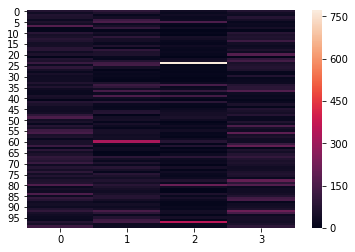

In [221]:
sns.heatmap(ptproj[:,trueandsel])

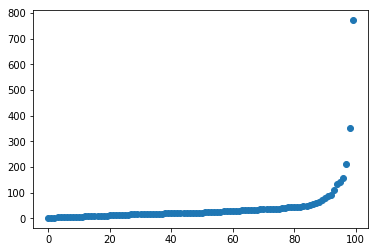

In [228]:
plt.scatter(list(range(100)), ppts[ppts[:,2].argsort(),2])

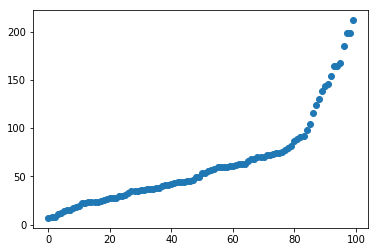

In [229]:
plt.scatter(list(range(100)), ppts[ppts[:,3].argsort(),3])

In [238]:
norms_ts = np.linalg.norm(replicates[r].dg_M[:,trueandsel,:], axis = 2)


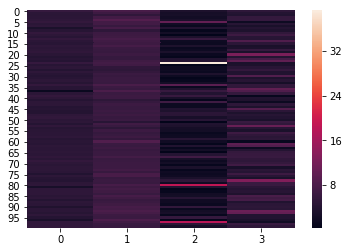

In [240]:
sns.heatmap(norms_ts)

Text(0.5, 1.0, '$g_2$')

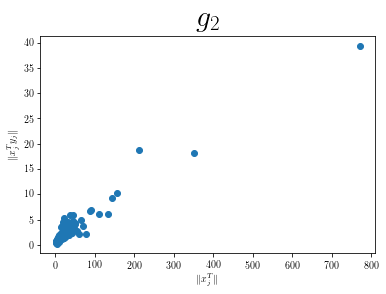

In [357]:
plt.scatter(ppts[:,2], norms_ts[:,2])
plt.xlabel(r'$\|x_j^T\|$')
plt.ylabel(r'$\|x_j^T y_j\|$')
plt.title(r'$g_2$')

In [360]:
np.where(ppts[:,3] > 100)[0]

array([14, 20, 23, 37, 53, 56, 61, 62, 67, 78, 80, 86, 87, 92, 93])

Text(0.5, 1.0, '$g_3$')

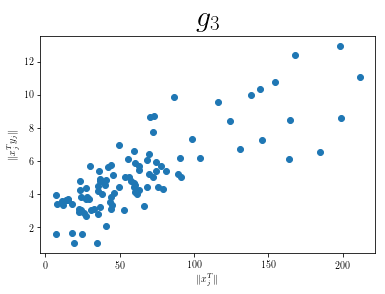

In [358]:
plt.scatter(ppts[:,3], norms_ts[:,3])
plt.xlabel(r'$\|x_j^T\|$')
plt.ylabel(r'$\|x_j^T y_j\|$')
plt.title(r'$g_3$')

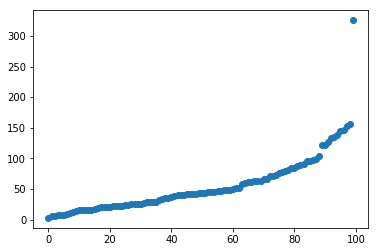

In [230]:
plt.scatter(list(range(100)), ppts[ppts[:,1].argsort(),1])

In [247]:
from codes.plotting.supportrecovery import plot_reg_path_ax_lambdasearch_customcolors_norm

In [248]:
colors = np.zeros((756,4))
colors[:,3] = 1
colors[:,2] = 1

In [252]:
xaxis_reorder[1]

543.4275237902186

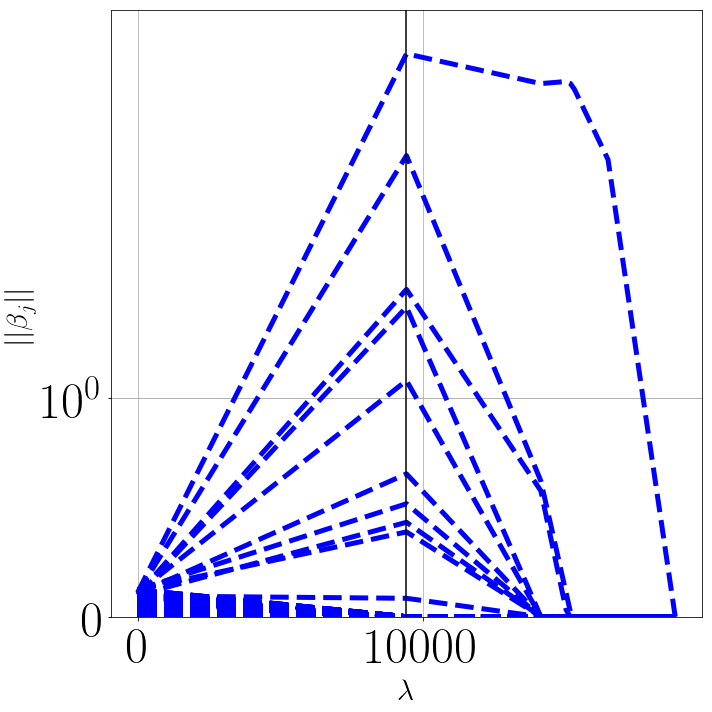

In [253]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
#mpl.style.use('default')
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_reorder * np.sqrt(nsel * m ) , f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30)
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30)

axarr.axvline(xaxis_reorder[1] * np.sqrt(nsel * m )  , color = 'black')
# axarr.text(xaxis_reorder[sell_plot] * np.sqrt(nsel * m ) , 1.5, r'$\lambda_{-1}$', fontsize = 40)
# axarr.axvline(xaxis_reorder[sell_plot-1]* np.sqrt(nsel * m )  , color = 'black')
# axarr.text(xaxis_reorder[sell_plot-1]* np.sqrt(nsel * m )  , 1.5, r'$\lambda_{0}$', fontsize = 40)
# axarr.set_title('Regularization path (single replicate)')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_fulldict_replicate')

#axarr.patch.set_facecolor('None')

In [62]:
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)
trueandsel = [74,176,423,324]
experiment.atoms4  = experiment.atoms4[trueandsel]
experiment.p  = 4
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel

In [65]:
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
nreps = 1
for i in range(nreps):
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0], selected_points = sp)
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


pre-gradient acquisition 2021-02-19 09:01:30.744126


In [69]:
dg_M_norm = np.linalg.norm(replicates[0].dg_M, axis =2)

In [73]:
r = 0
ptproj = np.linalg.norm(np.einsum('n m d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([2]))
ppts = ptproj#[:,trueandsel]

Text(0.5, 1.0, '$g_3$')

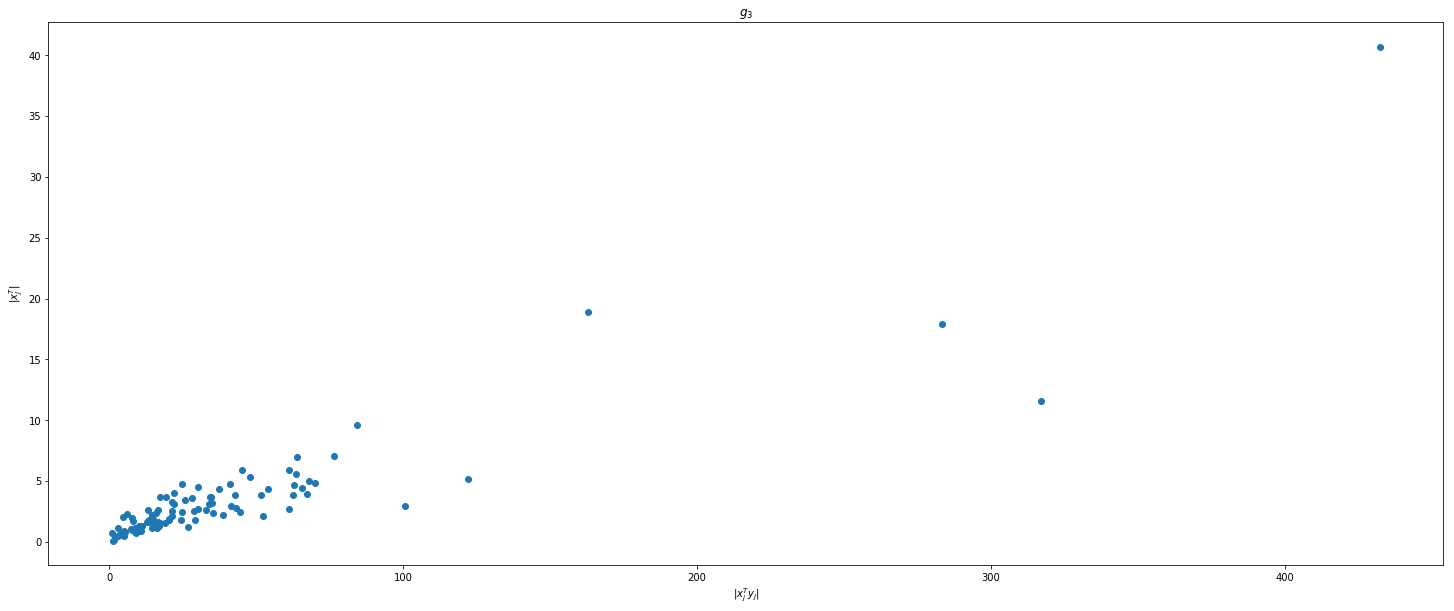

In [74]:
plt.scatter(ppts[:,2], dg_M_norm[:,2])
plt.ylabel(r'$\|x_j^T\|$')
plt.xlabel(r'$\|x_j^T y_j\|$')
plt.title(r'$g_3$')

Text(0.5, 1.0, '$g_3$')

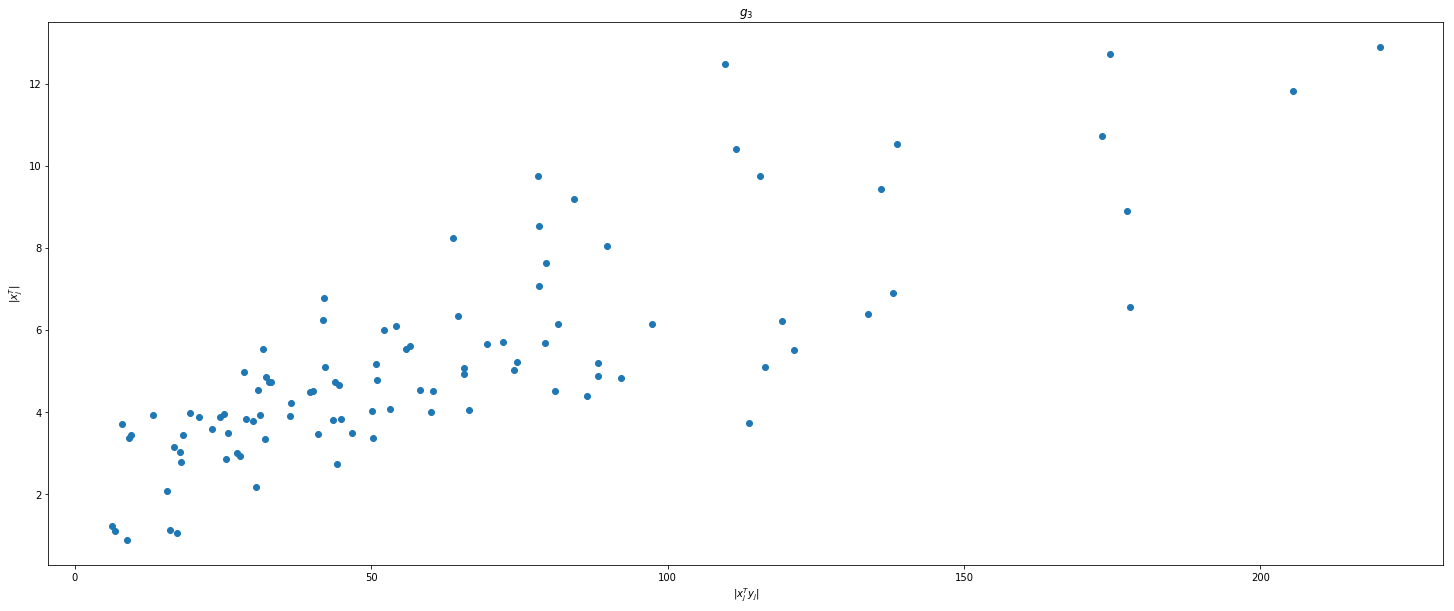

In [75]:
plt.scatter(ppts[:,3], dg_M_norm[:,3])
plt.ylabel(r'$\|x_j^T\|$')
plt.xlabel(r'$\|x_j^T y_j\|$')
plt.title(r'$g_3$')

In [77]:
ppts.shape

(100, 4)